In [1]:
from petsc4py import PETSc
import numpy as np
import pymgmc
import matplotlib.pyplot as plt

In [2]:
''' Setup the grid hierarchy. We're using a 65x65 coarse grid and refine two times. '''
n_coarse = 65
n_levels = 3

da = PETSc.DMDA().create([n_coarse, n_coarse], stencil_width=1, comm=PETSc.COMM_WORLD)
da_hierarchy = pymgmc.DMHierarchy(da, n_levels)

A = da_hierarchy.getFine().createMat()

In [3]:
''' Assemble the precision matrix given by a finite difference discretisation of ∆ - κ^2'''
kappainv = 1
kappa2   = 1. / (kappainv * kappainv)

def index_to_grid(r):
    """Convert a row number into a grid point."""
    return (r // n, r % n)

n,_ = da_hierarchy.getFine().getSizes()
h = 1.0 / (n + 1)

rstart, rend = A.getOwnershipRange()
for row in range(rstart, rend):
    i, j = index_to_grid(row)
    A[row, row] = 4.0 / h**2 + kappa2
    if i > 0:
        column = row - n
        A[row, column] = -1.0 / h**2
    if i < n - 1:
        column = row + n
        A[row, column] = -1.0 / h**2
    if j > 0:
        column = row - 1
        A[row, column] = -1.0 / h**2
    if j < n - 1:
        column = row + 1
        A[row, column] = -1.0 / h**2

A.assemblyBegin()
A.assemblyEnd()

# Create vectors for the target mean, the sample, and the "right-hand side" used in the samplers
sample, mean = A.createVecs()
mean.set(2)

rhs = sample.duplicate()
A.mult(mean, rhs)

# Finally, wrap A in a LinearOperator
op = pymgmc.LinearOperator(A)

In [4]:
sampler = pymgmc.GibbsSampler(op)

sample.set(2)
n_burnin = 100
for i in range(n_burnin):
    sampler.sample(rhs, sample)

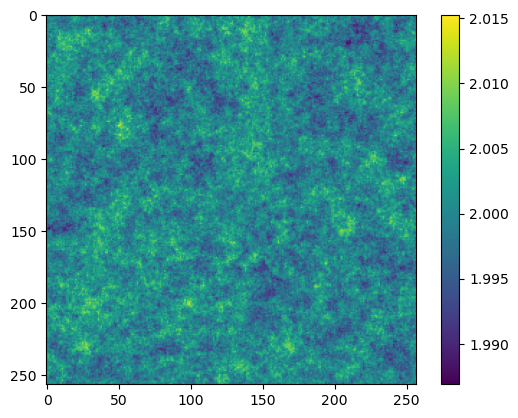

In [5]:
sampler.sample(rhs, sample)

arr = sample.getArray()
arr2d = np.reshape(arr, (n,n))

plt.imshow(arr2d)
plt.colorbar()
plt.show()

In [6]:
sampler_mgmc = pymgmc.MGMCSampler(op, da_hierarchy)

pymgmc.fillVecRand(sample)
n_burnin = 10
for i in range(n_burnin):
    sampler_mgmc.sample(rhs, sample)

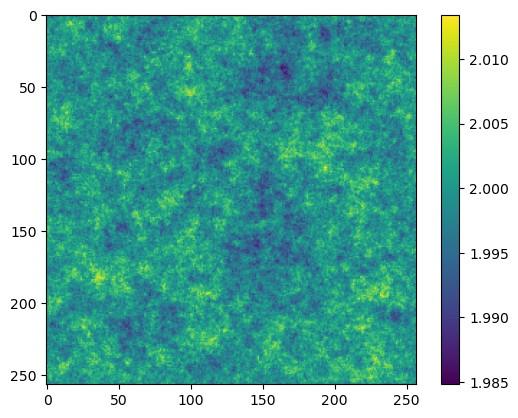

In [7]:
sampler_mgmc.sample(rhs, sample)

arr = sample.getArray()
arr2d = np.reshape(arr, (n,n))

plt.imshow(arr2d)
plt.colorbar()
plt.show()